In [51]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [52]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

# By country of citizenship

In [53]:
nationality = 'GUATEMALA'

In [54]:
removal_df = df[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')
transfer_df = df[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')

In [55]:
all_nationalities = removal_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique()
all_nationalities = all_nationalities.sort_values(ascending=False)
all_nationalities = all_nationalities.reset_index().reset_index()
all_nationalities['Rank'] = all_nationalities['index'] + 1
all_nationalities[all_nationalities['CountryOfCitizenship'] == nationality]

,index,CountryOfCitizenship,AlienMasterID,Rank
1,1,GUATEMALA,326783,2


In [56]:
nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

In [57]:
# Top pickup airports (removals and transfers)
nationality_df['air_AirportName'].value_counts().head(10)

Brownsville South Padre Island International Airport    101837
Phoenix-Mesa-Gateway Airport                             91546
Alexandria International Airport                         45008
San Antonio International Airport                        35256
Valley International Airport                             30878
El Paso International Airport                            18546
George Bush Intercontinental Houston Airport             13601
Harrisburg International Airport                         12088
Miami International Airport                              10933
San Diego International Airport                          10243
Name: air_AirportName, dtype: int64

In [58]:
# Top dropoff airports (removals and transfers)
nationality_df['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                 326592
Alexandria International Airport                   33945
Phoenix-Mesa-Gateway Airport                       25728
El Paso International Airport                       6013
Miami International Airport                         4123
Harrisburg International Airport                    2758
Boeing Field King County International Airport      2554
Newark Liberty International Airport                2549
San Antonio International Airport                   1915
Gary Chicago International Airport                  1899
Name: air2_AirportName, dtype: int64

In [59]:
nationality_df.set_index('MissionDate', inplace=True)

In [60]:
g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [61]:
table = g['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = g['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']
table['JuvenileCount'] = g['Juvenile'].sum().reset_index(name='JuvenileCount')['JuvenileCount']
table['JuvPercent'] = table['JuvenileCount'] / table['AlienMasterIDCount']
table['NCCount'] = g['NonCriminal'].sum().reset_index(name='NCCount')['NCCount']
table['NCPercent'] = table['NCCount'] / table['AlienMasterIDCount'] * 100

In [62]:
removals = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [63]:
removals.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [64]:
# Total removals
removals['AlienMasterIDCount'].sum()

326643

In [65]:
# Total removal flights
removals['MissionIDCount'].sum()

4246

In [66]:
# Total transfers
transfers['AlienMasterIDCount'].sum()

94586

In [67]:
weekly_removals = removals['AlienMasterIDCount'].resample('W').sum()
weekly_transfers = transfers['AlienMasterIDCount'].resample('W').sum()
monthly_removals = removals['AlienMasterIDCount'].resample('M').sum()
monthly_transfers = transfers['AlienMasterIDCount'].resample('M').sum()
monthly_removal_flights = removals['MissionIDCount'].resample('M').sum()
monthly_transfers_flights = transfers['MissionIDCount'].resample('M').sum()
annual_removals = removals['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_transfers = transfers['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_removal_flights = removals['MissionIDCount'].resample('AS-OCT').sum()
annual_transfer_flights = transfers['MissionIDCount'].resample('AS-OCT').sum()
annual_juvenile_removals = removals['JuvenileCount'].resample('AS-OCT').sum()

In [68]:
annual_removals

MissionDate
2010-10-01    30472
2011-10-01    38399
2012-10-01    47955
2013-10-01    54135
2014-10-01    32599
2015-10-01    32963
2016-10-01    32198
2017-10-01    48765
2018-10-01     9157
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [69]:
annual_juvenile_removals

MissionDate
2010-10-01    330.0
2011-10-01    251.0
2012-10-01    229.0
2013-10-01    149.0
2014-10-01     92.0
2015-10-01    160.0
2016-10-01    226.0
2017-10-01    363.0
2018-10-01    133.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [70]:
removals.reset_index(inplace=True, drop=False)
transfers.reset_index(inplace=True, drop=False)

In [71]:
removals.tail(20)

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
3998,2018-11-23,GUATEMALA,R,KIWA,MGGT,133,1,1.0,0.007519,91.0,68.421053
3999,2018-11-23,GUATEMALA,R,KBRO,MGGT,135,1,0.0,0.000000,129.0,95.555556
4000,2018-11-27,GUATEMALA,R,KELP,MGGT,43,1,4.0,0.093023,19.0,44.186047
4001,2018-11-27,GUATEMALA,R,KSAT,MGGT,39,1,0.0,0.000000,14.0,35.897436
4002,2018-11-27,GUATEMALA,R,KBRO,MGGT,96,1,4.0,0.041667,86.0,89.583333
4003,2018-11-28,GUATEMALA,R,KAEX,MGGT,42,1,0.0,0.000000,22.0,52.380952
4004,2018-11-28,GUATEMALA,R,KIWA,MGGT,129,1,0.0,0.000000,106.0,82.170543
4005,2018-11-28,GUATEMALA,R,KBRO,MGGT,135,1,0.0,0.000000,133.0,98.518519
4006,2018-11-29,GUATEMALA,R,KAEX,MGGT,115,1,0.0,0.000000,48.0,41.739130
4007,2018-11-29,GUATEMALA,R,KIAH,MGGT,63,1,3.0,0.047619,24.0,38.095238


In [72]:
transfers.head()

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2010-10-01,GUATEMALA,T,KDEN,KIWA,3,1,0.0,0.0,0.0,0.0
1,2010-10-01,GUATEMALA,T,KMCI,KAEX,6,1,0.0,0.0,0.0,0.0
2,2010-10-01,GUATEMALA,T,KMDT,KAEX,18,1,0.0,0.0,0.0,0.0
3,2010-10-01,GUATEMALA,T,KOAK,KIWA,2,1,0.0,0.0,0.0,0.0
4,2010-10-01,GUATEMALA,T,KOAK,KSAN,3,1,0.0,0.0,0.0,0.0


In [73]:
# transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
# removals.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [74]:
removals.set_index('MissionDate', inplace=True)

In [75]:
transfers.set_index('MissionDate', inplace=True)

In [76]:
r_cum = removals['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

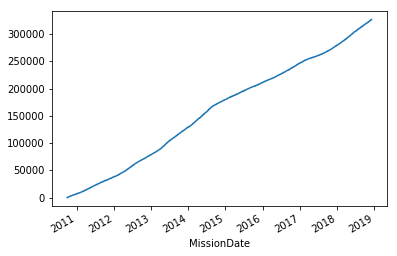

In [77]:
r_cum.plot()

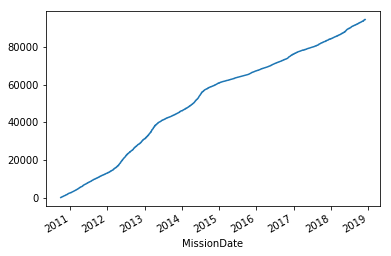

In [78]:
t_cum.plot()

In [79]:
g = nationality_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air_AirportName', 'air2_AirportName', 'air2_Country'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
removal_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [80]:
removal_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [81]:
removal_dropoff_airports

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
7,2010-10-01,R,Phoenix-Mesa-Gateway Airport,La Aurora Airport,Guatemala,10723,104
0,2010-10-01,R,Alexandria International Airport,La Aurora Airport,Guatemala,6091,53
8,2010-10-01,R,San Antonio International Airport,La Aurora Airport,Guatemala,4922,68
6,2010-10-01,R,Miami International Airport,La Aurora Airport,Guatemala,2078,53
9,2010-10-01,R,Valley International Airport,La Aurora Airport,Guatemala,2041,41
1,2010-10-01,R,Columbus Metropolitan Airport,La Aurora Airport,Guatemala,1743,26
4,2010-10-01,R,George Bush Intercontinental Houston Airport,La Aurora Airport,Guatemala,1551,37
2,2010-10-01,R,Dallas Love Field,La Aurora Airport,Guatemala,663,21
3,2010-10-01,R,El Paso International Airport,La Aurora Airport,Guatemala,532,19
11,2010-10-01,R,Brownsville South Padre Island International A...,La Aurora Airport,Guatemala,93,1


In [82]:
transfer_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
34,2010-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,2327,85
93,2010-10-01,T,San Diego International Airport,Phoenix-Mesa-Gateway Airport,USA,1644,95
57,2010-10-01,T,Metropolitan Oakland International Airport,Phoenix-Mesa-Gateway Airport,USA,592,170
94,2010-10-01,T,Toledo Express Airport,Alexandria International Airport,USA,568,48
21,2010-10-01,T,Chicago O'Hare International Airport,Alexandria International Airport,USA,445,50
29,2010-10-01,T,El Paso International Airport,Phoenix-Mesa-Gateway Airport,USA,427,36
31,2010-10-01,T,Eppley Airfield,Alexandria International Airport,USA,403,34
19,2010-10-01,T,Boeing Field King County International Airport,Phoenix-Mesa-Gateway Airport,USA,331,27
67,2010-10-01,T,Ontario International Airport,Phoenix-Mesa-Gateway Airport,USA,327,7
45,2010-10-01,T,Kansas City International Airport,Alexandria International Airport,USA,295,50


In [83]:
# Top pickup locations for transfer flights
transfer_dropoff_airports['air_AirportName'].value_counts().head(10)

Phoenix-Mesa-Gateway Airport                            145
Brownsville South Padre Island International Airport    105
San Antonio International Airport                        90
Alexandria International Airport                         88
Valley International Airport                             42
Laredo International Airport                             41
San Diego International Airport                          35
Metropolitan Oakland International Airport               33
El Paso International Airport                            27
Harrisburg International Airport                         26
Name: air_AirportName, dtype: int64

In [84]:
# Top dropoff locations for transfer flights
transfer_dropoff_airports['air2_AirportName'].value_counts().head(10)

Alexandria International Airport                        156
Phoenix-Mesa-Gateway Airport                            126
El Paso International Airport                            70
Miami International Airport                              40
Brownsville South Padre Island International Airport     38
San Antonio International Airport                        33
Harrisburg International Airport                         31
Boeing Field King County International Airport           29
Newark Liberty International Airport                     27
San Diego International Airport                          26
Name: air2_AirportName, dtype: int64

In [85]:
# removal_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
# transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [86]:
pivot = pd.pivot_table(data=removal_dropoff_airports,
                       index='MissionDate',
                       columns='air2_Country',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

In [87]:
pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)

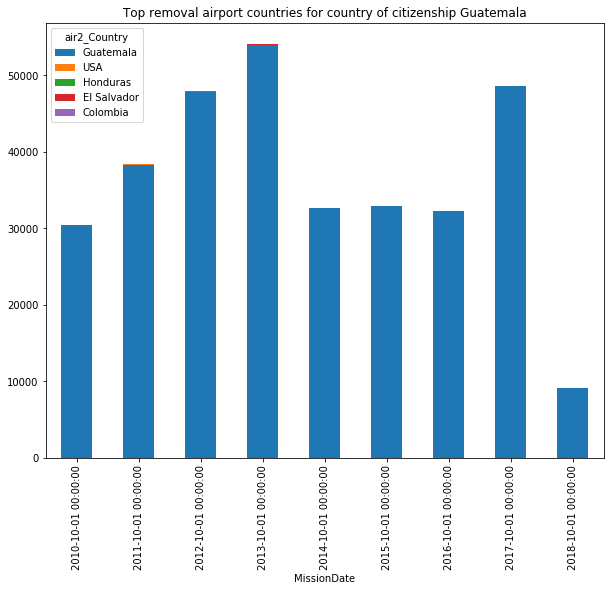

In [88]:
title = f"Top removal airport countries for country of citizenship {nationality.title()}"
fig = pivot.plot(kind='bar', stacked=True, figsize=(10, 8), title=title)

## Juveniles only

In [89]:
juv_r_cum = removals['JuvenileCount'].cumsum()

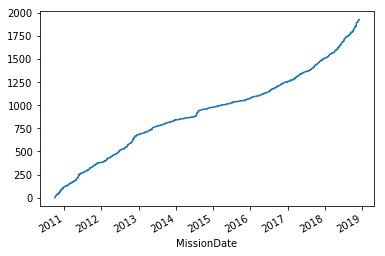

In [90]:
juv_r_cum.plot()

In [91]:
removals.tail(20)

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2018-11-23,GUATEMALA,R,KIWA,MGGT,133,1,1.0,0.007519,91.0,68.421053
2018-11-23,GUATEMALA,R,KBRO,MGGT,135,1,0.0,0.000000,129.0,95.555556
2018-11-27,GUATEMALA,R,KELP,MGGT,43,1,4.0,0.093023,19.0,44.186047
2018-11-27,GUATEMALA,R,KSAT,MGGT,39,1,0.0,0.000000,14.0,35.897436
2018-11-27,GUATEMALA,R,KBRO,MGGT,96,1,4.0,0.041667,86.0,89.583333
2018-11-28,GUATEMALA,R,KAEX,MGGT,42,1,0.0,0.000000,22.0,52.380952
2018-11-28,GUATEMALA,R,KIWA,MGGT,129,1,0.0,0.000000,106.0,82.170543
2018-11-28,GUATEMALA,R,KBRO,MGGT,135,1,0.0,0.000000,133.0,98.518519
2018-11-29,GUATEMALA,R,KAEX,MGGT,115,1,0.0,0.000000,48.0,41.739130


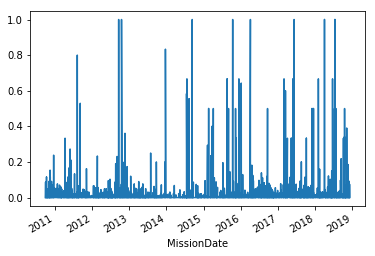

In [92]:
removals['JuvPercent'].plot();

In [93]:
removals[removals['JuvPercent'] > .5]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2011-08-11,GUATEMALA,R,KSAT,MGGT,5,1,4.0,0.800000,5.0,100.000000
2011-09-09,GUATEMALA,R,KHRL,MGGT,17,1,9.0,0.529412,17.0,100.000000
2012-09-20,GUATEMALA,R,KMIA,MGGT,1,1,1.0,1.000000,1.0,100.000000
2012-10-18,GUATEMALA,R,KMIA,MGGT,3,1,3.0,1.000000,3.0,100.000000
2013-12-23,GUATEMALA,R,KBRO,MGGT,6,1,5.0,0.833333,6.0,100.000000
2014-07-18,GUATEMALA,R,KROW,MGGT,12,1,7.0,0.583333,12.0,100.000000
2014-07-22,GUATEMALA,R,KROW,MGGT,21,1,14.0,0.666667,21.0,100.000000
2014-07-24,GUATEMALA,R,KROW,MGGT,21,1,12.0,0.571429,21.0,100.000000
2014-08-07,GUATEMALA,R,KROW,MGGT,24,1,13.0,0.541667,24.0,100.000000


In [94]:
transfers['JuvenileCount'].value_counts()

0.0     8312
1.0      150
2.0       58
5.0       53
3.0       52
4.0       50
6.0       44
7.0       41
8.0       39
10.0      35
12.0      35
11.0      32
9.0       32
13.0      23
17.0      14
14.0      13
15.0      12
20.0      10
18.0      10
16.0       8
25.0       8
21.0       7
23.0       6
19.0       6
34.0       5
42.0       5
26.0       5
35.0       4
36.0       4
24.0       4
28.0       3
39.0       3
38.0       3
22.0       3
32.0       2
40.0       2
54.0       2
65.0       2
46.0       2
33.0       2
29.0       1
27.0       1
50.0       1
43.0       1
30.0       1
37.0       1
47.0       1
49.0       1
31.0       1
Name: JuvenileCount, dtype: int64

In [95]:
removals[removals['JuvenileCount'] > 20]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2018-11-06,GUATEMALA,R,KSAT,MGGT,64,1,25.0,0.390625,52.0,81.25


# KBFI only

In [96]:
airport = 'KBFI'

In [97]:
airport_removals = removals[removals['PULOC'] == airport]

In [98]:
airport_removals

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2012-06-11,GUATEMALA,R,KBFI,MGGT,114,1,1.0,0.008772,102.0,89.473684


In [99]:
airport_transfers = transfers[transfers['PULOC'] == airport]

In [100]:
airport_weekly_removals = airport_removals['AlienMasterIDCount'].resample('W').nunique()
airport_weekly_transfers = airport_transfers['AlienMasterIDCount'].resample('W').nunique()
airport_monthly_removals = airport_removals['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_transfers = airport_transfers['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_removal_flights = airport_removals['MissionIDCount'].resample('M').nunique()
airport_monthly_transfers_flights = airport_transfers['MissionIDCount'].resample('M').nunique()
airport_annual_removals = airport_removals['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_transfers = airport_transfers['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_removal_flights = airport_removals['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_transfer_flights = airport_transfers['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_juvenile_removals = airport_removals['JuvenileCount'].resample('AS-OCT').sum()
airport_annual_juvenile_transfers = airport_transfers['JuvenileCount'].resample('AS-OCT').sum()

In [101]:
airport_annual_removals

MissionDate
2011-10-01    1
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [102]:
airport_annual_removal_flights

MissionDate
2011-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [103]:
airport_annual_juvenile_removals

MissionDate
2011-10-01    1.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [104]:
airport_annual_transfers

MissionDate
2010-10-01    17
2011-10-01    24
2012-10-01    21
2013-10-01    17
2014-10-01    15
2015-10-01    25
2016-10-01    13
2017-10-01    16
2018-10-01     6
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [105]:
airport_annual_transfer_flights

MissionDate
2010-10-01    1
2011-10-01    1
2012-10-01    1
2013-10-01    1
2014-10-01    1
2015-10-01    1
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [106]:
airport_annual_juvenile_transfers

MissionDate
2010-10-01    1.0
2011-10-01    1.0
2012-10-01    0.0
2013-10-01    1.0
2014-10-01    0.0
2015-10-01    0.0
2016-10-01    7.0
2017-10-01    1.0
2018-10-01    0.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

# Criminal status

 `Criminality` is not fully consistent with `Convictions`; especially in FY2010. 

In [107]:
removals['NCPercent']

MissionDate
2010-10-01     0.000000
2010-10-01     0.000000
2010-10-01     0.000000
2010-10-04     0.000000
2010-10-05     0.000000
2010-10-05     0.000000
2010-10-06     0.000000
2010-10-06     0.000000
2010-10-07     0.000000
2010-10-08     0.000000
2010-10-08     0.000000
2010-10-08     0.000000
2010-10-12     0.000000
2010-10-13     0.000000
2010-10-13     0.000000
2010-10-13     0.000000
2010-10-13     0.000000
2010-10-14     0.000000
2010-10-14     0.000000
2010-10-15     0.000000
2010-10-15     0.000000
2010-10-15     0.000000
2010-10-19     0.000000
2010-10-19     0.000000
2010-10-19     0.000000
2010-10-19     0.000000
2010-10-19     0.000000
2010-10-21     0.000000
2010-10-22     0.000000
2010-10-22     0.000000
                ...    
2018-11-20    55.737705
2018-11-20    50.980392
2018-11-20    47.169811
2018-11-20    61.290323
2018-11-20    59.259259
2018-11-20    99.074074
2018-11-21    41.525424
2018-11-21    35.616438
2018-11-21    78.030303
2018-11-21    99.259259
2018

In [108]:
removals['NCCount'].resample('AS-OCT').sum()

MissionDate
2010-10-01    17940.0
2011-10-01    28684.0
2012-10-01    38371.0
2013-10-01    45751.0
2014-10-01    25877.0
2015-10-01    24303.0
2016-10-01    23847.0
2017-10-01    33188.0
2018-10-01     6248.0
Freq: AS-OCT, Name: NCCount, dtype: float64

In [109]:
removals['AlienMasterIDCount'].resample('AS-OCT').sum()

MissionDate
2010-10-01    30472
2011-10-01    38399
2012-10-01    47955
2013-10-01    54135
2014-10-01    32599
2015-10-01    32963
2016-10-01    32198
2017-10-01    48765
2018-10-01     9157
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64